In [7]:
!pip install python-mnist

  Running setup.py bdist_wheel for python-mnist: started
  Running setup.py bdist_wheel for python-mnist: finished with status 'done'
  Stored in directory: C:\Users\tbop02\AppData\Local\pip\Cache\wheels\e3\67\aa\bea4c3dc84f590c0dabb8c00317b6b7f8e6bd43b095d7679d5
Successfully built python-mnist


In [25]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

### when the above code doesn't respond, excute just the below

In [24]:
from mnist import MNIST
import numpy as np
mndata = MNIST('datasets/MNIST/')

train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images=np.array(train_images)
train_labels=np.array(train_labels)
test_images=np.array(test_images)
test_labels=np.array(test_labels)

X=np.concatenate((train_images,test_images),axis=0)
y=np.concatenate((train_labels,test_labels),axis=0)

In [29]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


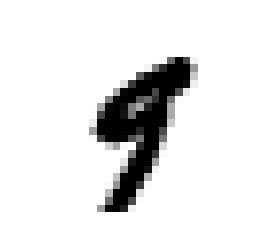

In [31]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [35]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [36]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

In [37]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [50]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=50)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [48]:
sgd_clf.predict([some_digit])

array([False])

### Measuring Accuracy Using Cross-Validation

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #Constructs a new estimator with the same parameters.
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.94625
0.88835
0.961


In [68]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.94625, 0.88835, 0.961  ])

don't be suprised

**dumb classifier which classify every answer False**

In [69]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [71]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91205, 0.91005, 0.90685])

In [77]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[51490,  3089],
       [  999,  4422]], dtype=int64)

Precision and Recall

In [82]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 4344 / (4344 + 1307)
print(recall_score(y_train_5, y_train_pred))

0.5887365197710025
0.8157166574432761


In [83]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6838849365914013

**Precision/Recall Tradeoff**

decision_function() method, which returns a score for each instance

In [88]:
y_scores = sgd_clf.decision_function([some_digit])
print('score',y_scores)
threshold = -20000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

score [-10488.93412238]
[ True]


In [87]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [89]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [90]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Plot precision vs recall

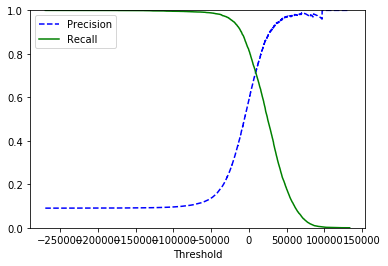

In [91]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

So let’s suppose you decide to aim for 90% precision.

In [97]:
y_train_pred_90 = (y_scores > 70000)
print('precision_score',precision_score(y_train_5, y_train_pred_90))
print('recall_score',recall_score(y_train_5, y_train_pred_90))

precision_score 0.9892857142857143
recall_score 0.051097583471684194


### The ROC Curve

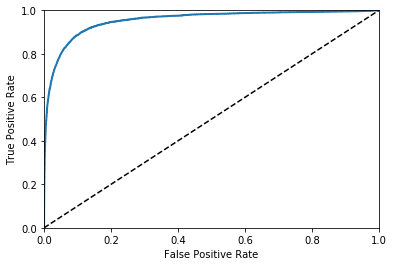

In [98]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [99]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9540136508477957

### RandomForestClassifier

In [101]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [102]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

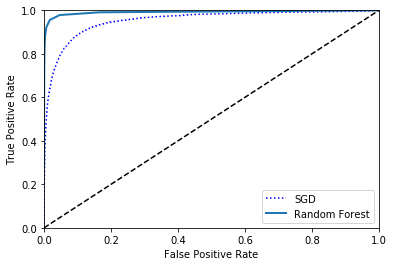

In [104]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

ROC curve looks much better than the SGDClassifier's

In [105]:
roc_auc_score(y_train_5, y_scores_forest)

0.9918928190344147

### Multiclass Classification

In [106]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Scikit-Learns detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA

In [107]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -74529.20494447,  -56275.68949771,  -78678.31378181,
          -6575.02882366,   -6629.43894421,  -10488.93412238,
        -112203.16511417,  -33694.00560765,  -27003.37394613,
          -8679.06551108]])

In [108]:
np.argmax(some_digit_scores)

3

In [109]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [111]:
sgd_clf.classes_[5]

5

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

If you want to force ScikitLearn to use one-versus-one or one-versus-all

OneVsOneClassifier or OneVsRestClassifierm

In [114]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=30))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

because 10C2

In [116]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=uint8)

In [119]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.9]])

it menas that random forest classifier predict this sample 9 with 90% probability

In [117]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88682264, 0.85304265, 0.88113217])

In [118]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90791842, 0.91504575, 0.91228684])

In [121]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90791842, 0.91504575, 0.91228684])

just simpy standardSCalar can increase accuracy because this is kind of SGD

### Error Analysis